# 0. Environment, Package, Configuration, Seed, CUDA

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import time
import datetime
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

2025-12-11 18:51:40.043157: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 18:51:40.998968: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
CONFIG = {
    'seed': 42,
    'batch_size': 32,
    'max_len': 128,
    'epochs': 3,
    'lr': 2e-5,
    'eps': 1e-8,
    'warmup_ratio': 0.1,
    'model_name': 'bert-base-multilingual-cased',
    'train_path': 'dataset/processed/train.csv',
    'test_path': 'dataset/processed/test.csv'
}

In [3]:
# Set random seed (Reproducibility)
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(CONFIG['seed'])
print('Set seed to %d.' % CONFIG['seed'])

Set seed to 42.


In [4]:
# check CUDA
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('Using the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Using the GPU: NVIDIA GeForce GTX 1060 6GB


# 1. Loading and Preprocessing Data

In [5]:
train_df = pd.read_csv(CONFIG['train_path'])
print('Number of samples: ', len(train_df))
train_df.head()

Number of samples:  14691


,Comment,Sentiment
0,it’s so adorable that he says “baap” for up an...,positive
1,sir i have no words to describe your teaching ...,positive
2,the reason they said large and open space inst...,neutral
3,for ur information this is an fact that jrntr ...,neutral
4,you can really tell the progress awesome espec...,positive


In [6]:
test_df = pd.read_csv(CONFIG['test_path'])
print('Number of samples: ', len(test_df))
test_df.head()

Number of samples:  3673


,Comment,Sentiment
0,“oh my god guys there’s an octopus eating a cr...,negative
1,my daughter will be starting her 8th grade che...,positive
2,for some future video you should definitely bu...,neutral
3,i’m chronically ill and very frequently find i...,positive
4,the pizza planet pizza being awful is just dis...,negative


In [7]:
# Define label Mapping
label_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

# convert label
def convert_label(df):
    df['label'] = df['Sentiment'].map(label_map)
    df = df.dropna(subset=['label']) # remove uncovered label (e.g., 'Other')
    df['label'] = df['label'].astype(int)
    return df

train_df = convert_label(train_df)
test_df = convert_label(test_df)

In [8]:
train_texts = train_df["Comment"].values
train_labels = train_df["label"].values
test_texts = test_df["Comment"].values
test_labels = test_df["label"].values

In [9]:
print(f"  Train rows: {len(train_df)}")
print(f"  Train class distribution: {train_df['label'].value_counts().to_dict()}")
print(f"  Test rows: {len(test_df)}")
print(f"  Test class distribution: {test_df['label'].value_counts().to_dict()}")

  Train rows: 14691
  Train class distribution: {2: 9121, 1: 3700, 0: 1870}
  Test rows: 3673
  Test class distribution: {2: 2281, 1: 925, 0: 467}


# 2. Train / Validation Split (with Stratify)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    train_texts,
    train_labels,
    test_size=0.2,
    random_state=CONFIG['seed'],
    stratify=train_labels
)

print(f"Train: {len(X_train)}")
print(f"Val:   {len(X_val)}")
print(f"Test:  {len(test_texts)}")

Train: 11752
Val:   2939
Test:  3673


# 3. Tokenization (using Multilingual model)

In [11]:
tokenizer = BertTokenizer.from_pretrained(CONFIG['model_name'])

def encode_texts(texts):
    encoded_batch = tokenizer(
        texts.tolist() if isinstance(texts, np.ndarray) else list(texts),
        add_special_tokens=True,
        max_length=CONFIG['max_len'],
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoded_batch['input_ids'], encoded_batch['attention_mask']

train_inputs, train_masks = encode_texts(X_train)
validation_inputs, validation_masks = encode_texts(X_val)
test_inputs, test_masks = encode_texts(test_texts)

train_labels = torch.tensor(y_train)
validation_labels = torch.tensor(y_val)
test_labels = torch.tensor(test_labels)


In [12]:
# Building Training DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=CONFIG['batch_size'])

# Building Validation DataLoader
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=CONFIG['batch_size'])

# Building Test DataLoader
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=CONFIG['batch_size'])

# 4. Model Initialization

In [13]:
model = BertForSequenceClassification.from_pretrained(
    CONFIG['model_name'], 
    num_labels = 3, 
    output_attentions = False, 
    output_hidden_states = False, 
)

model.cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], eps=CONFIG['eps'])
total_steps = len(train_dataloader) * CONFIG['epochs']
num_warmup_steps = int(total_steps * CONFIG['warmup_ratio'])
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 5. Training Loop

In [14]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

In [15]:
print("Start Training...")
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, CONFIG['epochs']):
    
    # --- Training ---
    print(f'\n======== Epoch {epoch_i + 1} / {CONFIG["epochs"]} ========')
    t0 = time.time()
    total_train_loss = 0
    model.train()

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch_i+1} Training", leave=False)

    for step, batch in enumerate(progress_bar):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        # Forward Pass
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        total_train_loss += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_train_loss = total_train_loss / len(train_dataloader)         
    training_time = format_time(time.time() - t0)
    print(f"Training Loss: {avg_train_loss:.2f} | Time: {training_time}")

    
    # --- Validation ---
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels, 
                           return_dict=True)

        logits = result.logits
        loss = result.loss
        total_eval_loss += loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Compute Accuracy
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        total_eval_accuracy += np.sum(pred_flat == labels_flat) / len(labels_flat)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    val_time = format_time(time.time() - t0)
    print(f"Val Loss: {avg_val_loss:.2f} | Val Accuracy: {avg_val_accuracy:.2f} | Time: {val_time}")

    

print(f"\nTotal Training Time: {format_time(time.time()-total_t0)}")

Start Training...

======== Epoch 1 / 3 ========


Epoch 1 Training:   0%|          | 0/368 [00:00<?, ?it/s]

Training Loss: 0.64 | Time: 0:05:56
Val Loss: 0.47 | Val Accuracy: 0.80 | Time: 0:00:30

======== Epoch 2 / 3 ========


Epoch 2 Training:   0%|          | 0/368 [00:00<?, ?it/s]

Training Loss: 0.40 | Time: 0:05:57
Val Loss: 0.47 | Val Accuracy: 0.81 | Time: 0:00:31

======== Epoch 3 / 3 ========


Epoch 3 Training:   0%|          | 0/368 [00:00<?, ?it/s]

Training Loss: 0.26 | Time: 0:05:58
Val Loss: 0.48 | Val Accuracy: 0.82 | Time: 0:00:31

Total Training Time: 0:19:22


# 6. Test Set Evaluation

In [16]:
print("\nRunning Final Test Set Evaluation...")

model.eval()
test_preds = []
test_true_labels = []

for batch in tqdm(test_dataloader, desc="Testing"):
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    with torch.no_grad():        
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

    logits = result.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    test_preds.extend(np.argmax(logits, axis=1).flatten())
    test_true_labels.extend(label_ids.flatten())

final_accuracy = accuracy_score(test_true_labels, test_preds)
print(f"Test Accuracy: {final_accuracy:.2f}")

print("\nTest Set Classification Report:")
print(classification_report(test_true_labels, test_preds, target_names=['Negative', 'Neutral', 'Positive']))


Running Final Test Set Evaluation...


Testing:   0%|          | 0/115 [00:00<?, ?it/s]

Test Accuracy: 0.82

Test Set Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.68      0.69       467
     Neutral       0.69      0.70      0.69       925
    Positive       0.90      0.90      0.90      2281

    accuracy                           0.82      3673
   macro avg       0.76      0.76      0.76      3673
weighted avg       0.82      0.82      0.82      3673



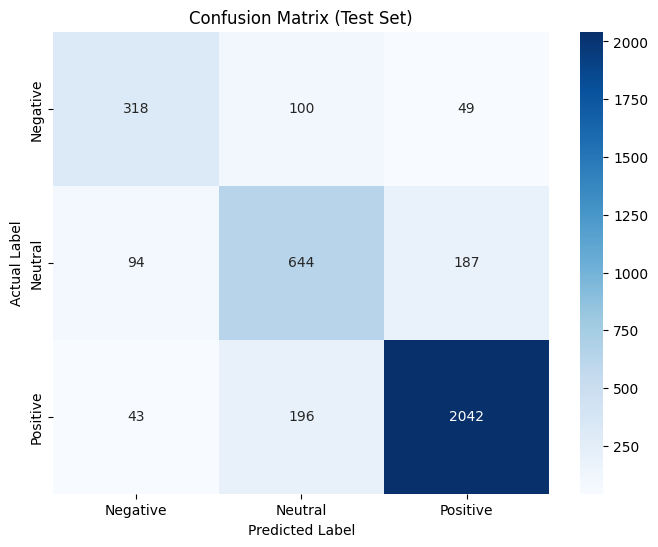

In [17]:
cm = confusion_matrix(test_true_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

In [18]:
# === Saving the prediction on Test set into CSV ===

X_test = test_texts
y_test = test_labels.cpu().numpy() if torch.is_tensor(test_labels) else test_labels

# make sure X_test / y_test and test_preds have same len
print("len(X_test):", len(X_test))
print("len(y_test):", len(y_test))
print("len(test_preds):", len(test_preds))

results_df = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "pred_label": test_preds
})

label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
results_df["true_label_str"] = results_df["true_label"].map(label_map)
results_df["pred_label_str"] = results_df["pred_label"].map(label_map)

# Save as CSV
output_path = "outputs/bert/test_predictions.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
results_df.to_csv(output_path, index=False)
print(f"Saved: {output_path}")
results_df.head()


len(X_test): 3673
len(y_test): 3673
len(test_preds): 3673
Saved: outputs/bert/test_predictions.csv


,text,true_label,pred_label,true_label_str,pred_label_str
0,“oh my god guys there’s an octopus eating a cr...,0,1,Negative,Neutral
1,my daughter will be starting her 8th grade che...,2,2,Positive,Positive
2,for some future video you should definitely bu...,1,1,Neutral,Neutral
3,i’m chronically ill and very frequently find i...,2,2,Positive,Positive
4,the pizza planet pizza being awful is just dis...,0,0,Negative,Negative
